In [71]:
import os
import random
from PIL import Image, ImageFile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sklearn.decomposition import PCA

from typing import List, Tuple


import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from tqdm import tqdm
import lpips, math, matplotlib.pyplot as plt
from pathlib import Path

In [72]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.02):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [55]:
class AnimeDataset(Dataset):
    """Random‑crop super‑resolution dataset with optional colour + flip aug.

    Args:
        image_paths (List[str]): HR image paths.
        hr_size (int): HR crop size (default 128).
        scale (int): upscale factor (default 4).
        augment (bool): enable RandomH/V flip + ColourJitter.
    """
    def __init__(self, image_paths: List[str], hr_size: int = 256,
                 scale: int = 4, augment: bool = False):
        self.image_paths = image_paths
        self.hr_size = hr_size
        self.lr_size = hr_size // scale
        self.augment = augment

        if augment:
            self.aug_t = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),   #  ← NEW vertical flip
                transforms.ColorJitter(brightness=0.3, contrast=0.3,
                                         saturation=0.3, hue=0.1),
            ])
        self.to_tensor = transforms.ToTensor()
        self.noise = AddGaussianNoise(0.0, 0.01)

    def __len__(self):
        return len(self.image_paths)

    def _rand_hr_crop(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if w < self.hr_size or h < self.hr_size:
            pad_w = max(self.hr_size - w, 0)
            pad_h = max(self.hr_size - h, 0)
            img = transforms.functional.pad(img, (0, 0, pad_w, pad_h))
            w, h = img.size
        left = random.randint(0, w - self.hr_size)
        top = random.randint(0, h - self.hr_size)
        return img.crop((left, top, left + self.hr_size, top + self.hr_size))

    def __getitem__(self, idx: int):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.augment:
            img = self.aug_t(img)
        hr = self._rand_hr_crop(img)
        lr = hr.resize((self.lr_size, self.lr_size), Image.BICUBIC)

        hr_t = self.noise(self.to_tensor(hr))
        lr_t = self.noise(self.to_tensor(lr))
        return lr_t * 2.0 - 1.0, hr_t * 2.0 - 1.0  # map to (‑1,1)

In [56]:
# Create list of image paths and split into train/validation/test sets.
image_dir = 'dataset'  # Update with your image folder
all_image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)
                   if img.endswith('.jpg') or img.endswith('.png')]
random.shuffle(all_image_paths)
total_size = len(all_image_paths)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size+val_size]
test_paths = all_image_paths[train_size+val_size:]

# Use augmentation only on training data.
train_dataset = AnimeDataset(train_paths, augment=True)
val_dataset = AnimeDataset(val_paths, augment=False)
test_dataset = AnimeDataset(test_paths, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [73]:
class ResBlock(nn.Module):
    """Two 3×3 convolutions + residual scaling (EDSR style)."""
    def __init__(self, channels: int, scale: float = 0.2):
        super().__init__()
        self.scale = scale
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.act   = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.conv2(self.act(self.conv1(x))) * self.scale
        return x + res

In [74]:
class ResDecoder(nn.Module):
    """Upscaler with 2× PixelShuffle stages (overall ×4)."""
    def __init__(self, in_channels: int = 3, base_channels: int = 64, n_blocks: int = 16):
        super().__init__()
        self.head = nn.Conv2d(in_channels, base_channels, 3, 1, 1)
        self.body = nn.Sequential(*[ResBlock(base_channels) for _ in range(n_blocks)])
        self.up1 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.tail = nn.Conv2d(base_channels, 3, 3, 1, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.head(x)
        x = self.body(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.tail(x)
        return torch.tanh(x)

In [9]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layers: Tuple[int, ...] = (2, 7, 16), layer_weights: List[float] | None = None):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.eval()
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg_partial = nn.Sequential(*[vgg[i] for i in range(max(layers) + 1)])
        self.layers = layers
        if layer_weights is None:
            layer_weights = [1.0] * len(layers)
        self.register_buffer("layer_weights", torch.tensor(layer_weights).view(-1, 1, 1, 1))
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std",  torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    @torch.no_grad()
    def _preprocess(self, x: torch.Tensor) -> torch.Tensor:
        return (x.add(1).div(2) - self.mean) / self.std

    def forward(self, sr: torch.Tensor, hr: torch.Tensor) -> torch.Tensor:
        sr_n = self._preprocess(sr)
        hr_n = self._preprocess(hr)
        feats_sr, feats_hr = [], []
        x_sr, x_hr = sr_n, hr_n
        for i, layer in enumerate(self.vgg_partial):
            x_sr = layer(x_sr)
            x_hr = layer(x_hr)
            if i in self.layers:
                feats_sr.append(x_sr)
                feats_hr.append(x_hr)
        loss = 0.0
        for w, fs, fh in zip(self.layer_weights, feats_sr, feats_hr):
            if fs.shape[-2:] != fh.shape[-2:]:
                fs = F.interpolate(fs, size=fh.shape[-2:], mode="bilinear", align_corners=False)
            loss += w * F.l1_loss(fs, fh)
        return loss

In [10]:
class SRLoss(nn.Module):
    """Returns **tuple** → (l1, perceptual, total).  Inputs expected in (‑1,1)."""
    def __init__(self, λ_pix: float = 1.0, λ_perc: float = 0.15):
        super().__init__()
        self.λ_pix, self.λ_perc = λ_pix, λ_perc
        self.perc_loss = VGGPerceptualLoss()

    def forward(self, sr: torch.Tensor, hr: torch.Tensor):
        l1   = F.l1_loss(sr, hr)
        perc = self.perc_loss(sr, hr)
        total = self.λ_pix * l1 + self.λ_perc * perc
        return l1, perc, total

In [75]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = ResDecoder().to(device)
criterion = SRLoss(λ_pix=1.0, λ_perc=0.2).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=8e-4,                   # ← Unicode hyphen here
    betas=(0.9, 0.999),
    weight_decay=5e-5          # ← And here too
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50, verbose=True)




In [10]:
num_epochs  = 450
best_val    = float("inf")
log_path    = Path("loss_log.txt")
log_path.write_text("epoch,train_l1,train_perc,val_l1,val_perc,train_total,val_total,learning_rate\n")  # header
for epoch in range(1, num_epochs + 1):
    # ---- train ----
    model.train()
    train_l1 = train_perc = train_total = n_train = 0
    for lr, hr in train_loader:           # (lr: 128×128, hr: 512×512)
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        l1, perc, total = criterion(sr, hr)
        total.backward()
        optimizer.step()
        b = lr.size(0)
        train_l1   += l1.item()   * b
        train_perc += perc.item() * b
        train_total+= total.item()* b
        n_train    += b

    # ---- validate ----
    model.eval()
    val_l1 = val_perc = val_total = n_val = 0
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            l1, perc, total = criterion(sr, hr)
            b = lr.size(0)
            val_l1   += l1.item()   * b
            val_perc += perc.item() * b
            val_total+= total.item()* b
            n_val    += b

    # ---- averages ----
    tl1, tp, tt = train_l1/n_train, train_perc/n_train, train_total/n_train
    vl1, vp, vt = val_l1/n_val,   val_perc/n_val,   val_total/n_val
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch:3d}/{num_epochs} | "
          f"Train  L1:{tl1:.4f}  Perc:{tp:.4f}  Total:{tt:.4f} | "
          f"Val  L1:{vl1:.4f}  Perc:{vp:.4f}  Total:{vt:.4f} | "
          f"LR:{current_lr:.1e}")

    # ---- log to file ----
    with log_path.open("a") as f:
        f.write(f"{epoch},{tl1:.6f},{tp:.6f},{vl1:.6f},{vp:.6f},{tt:.6f},{vt:.6f},{current_lr:.8f}\n")

    # ---- LR schedule & checkpoint ----
    scheduler.step(vt)
    if vt < best_val:
        best_val = vt
        torch.save(model.state_dict(), "SR4_best.pth")
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"SR4_epoch_{epoch}.pth")

print("\nTraining complete. Best validation loss:", best_val)

Epoch   1/450 | Train  L1:0.3743  Perc:6.3385  Total:1.6420 | Val  L1:0.2149  Perc:6.8216  Total:1.5793 | LR:8.0e-04
Epoch   2/450 | Train  L1:0.1811  Perc:6.3302  Total:1.4471 | Val  L1:0.1421  Perc:6.3178  Total:1.4057 | LR:8.0e-04
Epoch   3/450 | Train  L1:0.1332  Perc:5.9275  Total:1.3187 | Val  L1:0.1201  Perc:5.6319  Total:1.2464 | LR:8.0e-04
Epoch   4/450 | Train  L1:0.1163  Perc:5.3946  Total:1.1953 | Val  L1:0.1018  Perc:5.2149  Total:1.1448 | LR:8.0e-04
Epoch   5/450 | Train  L1:0.0979  Perc:5.3428  Total:1.1664 | Val  L1:0.0813  Perc:5.3606  Total:1.1534 | LR:8.0e-04
Epoch   6/450 | Train  L1:0.0822  Perc:5.3648  Total:1.1551 | Val  L1:0.0781  Perc:5.1912  Total:1.1163 | LR:8.0e-04
Epoch   7/450 | Train  L1:0.0745  Perc:5.1108  Total:1.0966 | Val  L1:0.0746  Perc:4.7733  Total:1.0293 | LR:8.0e-04
Epoch   8/450 | Train  L1:0.0791  Perc:5.0492  Total:1.0889 | Val  L1:0.0911  Perc:5.6093  Total:1.2129 | LR:8.0e-04
Epoch   9/450 | Train  L1:0.0780  Perc:5.1241  Total:1.1028 | Va

C:\Users\ruhalis\AppData\Local\Temp\ipykernel_11968\4058082585.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/SR4_epoch_400.pt

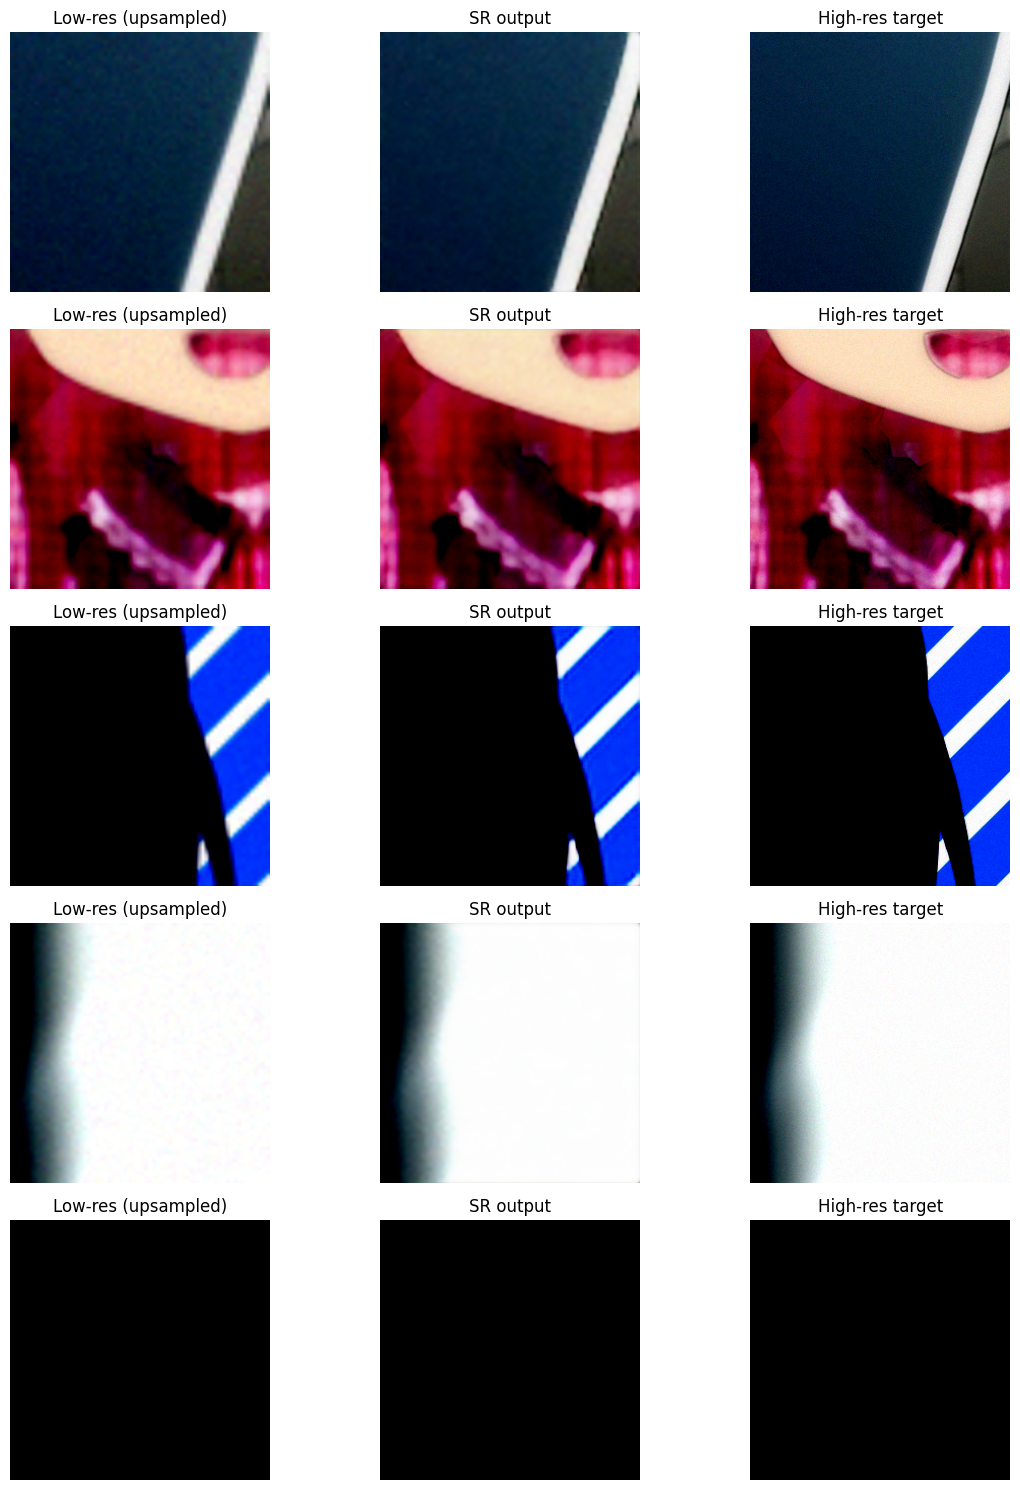

In [16]:
# Load the SR model
model.load_state_dict(torch.load('weights/SR4_epoch_400.pth', map_location=device))
model.eval()

# Show before & after on some test images
with torch.no_grad():
    low_res_batch, high_res_batch = next(iter(test_loader))
    low_res_batch = low_res_batch.to(device)
    high_res_batch = high_res_batch.to(device)

    # Get SR output
    recon_batch = model(low_res_batch)

    # Upsample low‑res for display
    low_res_upsampled = F.interpolate(
        low_res_batch,
        size=high_res_batch.shape[-2:], 
        mode='bilinear', 
        align_corners=False
    )

    # Convert to numpy for plotting
    low_np = low_res_upsampled.cpu().permute(0,2,3,1).numpy()
    recon_np = recon_batch.cpu().permute(0,2,3,1).numpy()
    high_np = high_res_batch.cpu().permute(0,2,3,1).numpy()

# Plot a few examples
num = min(5, low_np.shape[0])
fig, axes = plt.subplots(num, 3, figsize=(12, 3*num))
for i in range(num):
    axes[i,0].imshow(low_np[i]);   axes[i,0].axis('off'); axes[i,0].set_title('Low‑res (upsampled)')
    axes[i,1].imshow(recon_np[i]); axes[i,1].axis('off'); axes[i,1].set_title('SR output')
    axes[i,2].imshow(high_np[i]);  axes[i,2].axis('off'); axes[i,2].set_title('High‑res target')
plt.tight_layout()
plt.show()


C:\Users\ruhalis\AppData\Local\Temp\ipykernel_11340\2170389736.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

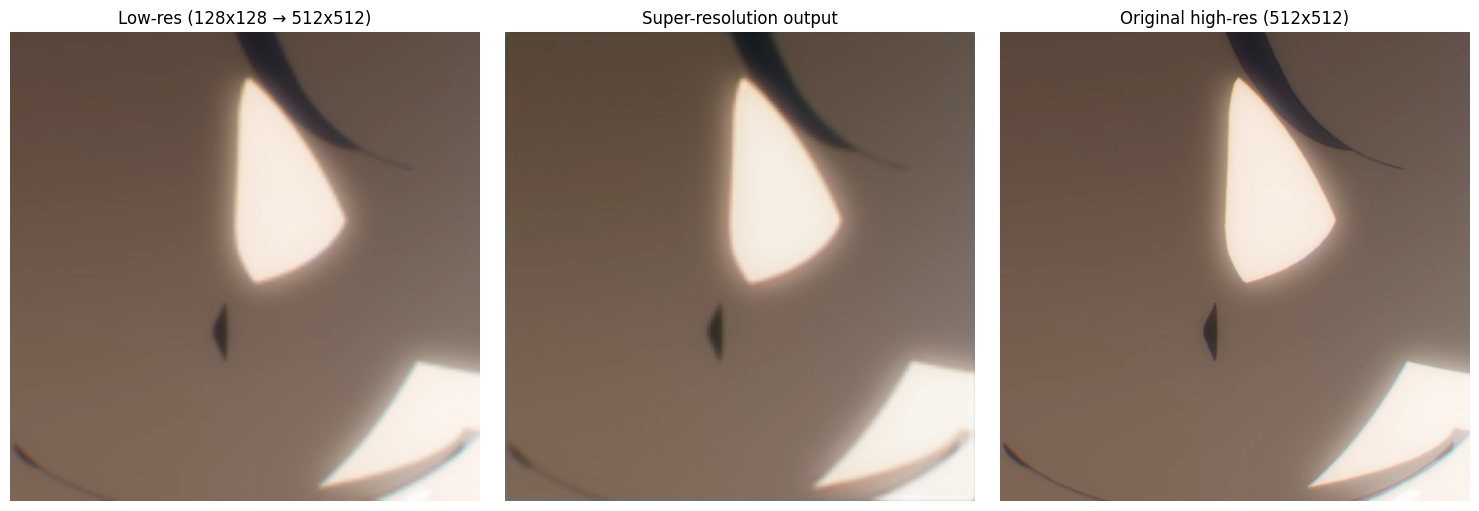

PSNR: 31.63 dB


In [12]:

model_path = f"SR3_epoch_120.pth"  # Adjust the format if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
# Path to your image
image_path = "dataset/assault_lily_bouquet_1.png"  # Replace with your image path

# Load the image and convert to RGB
original_img = Image.open(image_path).convert('RGB')

# Create a transform to crop and then create both high-res and low-res versions
def process_image(img, crop_size=512, low_res_size=128):
    # Get dimensions
    width, height = img.size
    
    # If image is smaller than crop_size, resize it up
    if width < crop_size or height < crop_size:
        scale = crop_size / min(width, height) * 1.2  # Scale up a bit
        new_width, new_height = int(width * scale), int(height * scale)
        img = img.resize((new_width, new_height), Image.LANCZOS)
        width, height = img.size
    
    # Calculate center crop coordinates
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    
    # Crop to square
    img_cropped = img.crop((left, top, right, bottom))
    
    # Create low-res version by resizing down
    img_low_res = img_cropped.resize((low_res_size, low_res_size), Image.BICUBIC)
    
    # Convert both to tensors [-1, 1] range as expected by your model
    to_tensor = T.ToTensor()
    hr_tensor = to_tensor(img_cropped) * 2.0 - 1.0
    lr_tensor = to_tensor(img_low_res) * 2.0 - 1.0
    
    return img_cropped, img_low_res, hr_tensor, lr_tensor

# Process the image
img_hr, img_lr, hr_tensor, lr_tensor = process_image(original_img)

# Add batch dimension
lr_tensor = lr_tensor.unsqueeze(0).to(device)
hr_tensor = hr_tensor.unsqueeze(0).to(device)

# Ensure model is in eval mode
model.eval()

# Run inference
with torch.no_grad():
    # Get SR output
    sr_tensor = model(lr_tensor)
    
    # Upsample low-res for display (this is what traditional upscaling would look like)
    lr_upsampled = F.interpolate(lr_tensor, size=(512, 512), mode='bilinear', align_corners=False)
    
    # Convert to numpy for plotting (change from [-1,1] to [0,1] range for displaying)
    lr_np = lr_upsampled.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    sr_np = sr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    hr_np = hr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    
    # Clip values to [0,1] range
    lr_np = np.clip(lr_np, 0, 1)
    sr_np = np.clip(sr_np, 0, 1)
    hr_np = np.clip(hr_np, 0, 1)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(lr_np)
plt.title("Low-res (128x128 → 512x512)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sr_np)
plt.title("Super-resolution output")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_np)
plt.title("Original high-res (512x512)")
plt.axis('off')

plt.tight_layout()
plt.show()

# You can also calculate metrics to evaluate the quality
psnr = -10 * torch.log10(F.mse_loss(sr_tensor, hr_tensor)).item()
print(f"PSNR: {psnr:.2f} dB")

C:\Users\ruhalis\AppData\Local\Temp\ipykernel_11968\1419963087.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

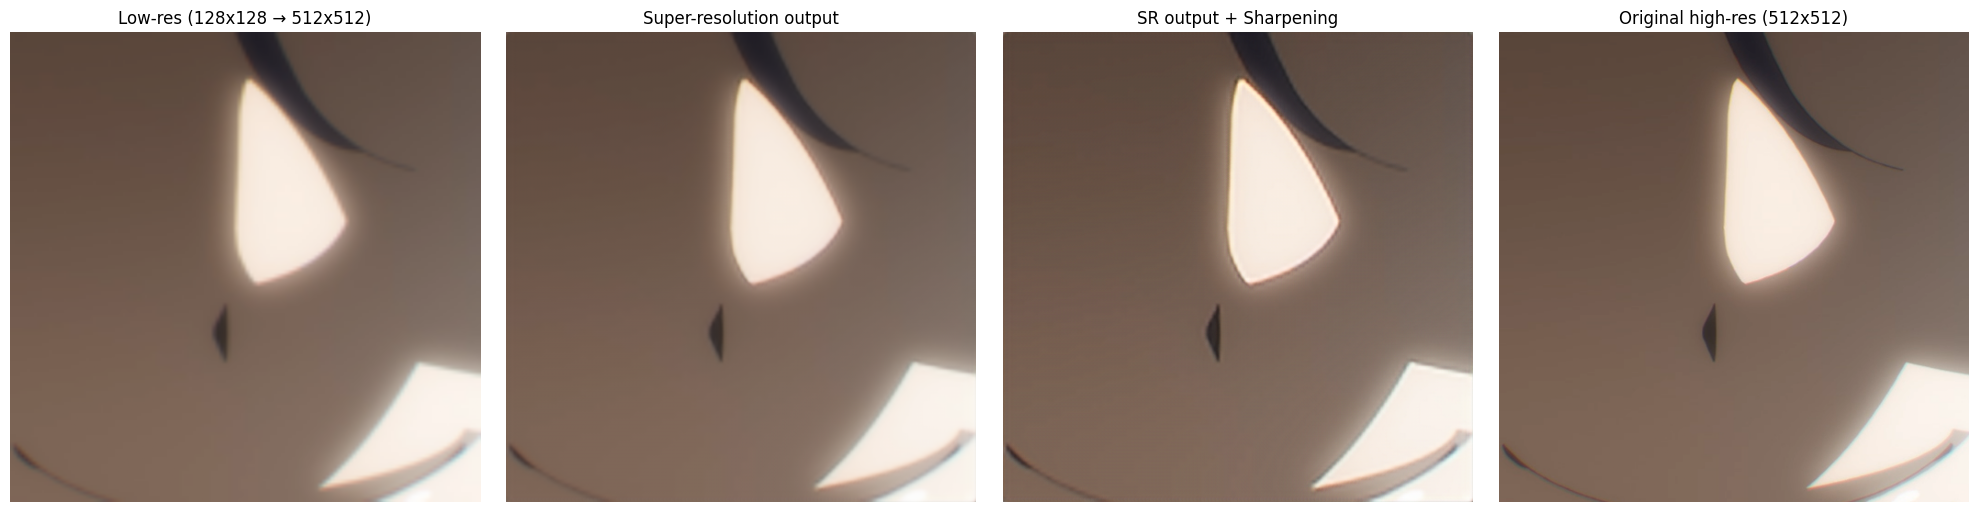

PSNR (Original SR): 37.82 dB
PSNR (Sharpened SR): 33.65 dB


In [21]:

import cv2
model_path = f"weights/SR4_epoch_400.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Path to your image
image_path = "dataset/assault_lily_bouquet_1.png"

# Load the image and convert to RGB
original_img = Image.open(image_path).convert('RGB')

# Create a transform to crop and then create both high-res and low-res versions
def process_image(img, crop_size=512, low_res_size=128):
    # Get dimensions
    width, height = img.size
    
    # If image is smaller than crop_size, resize it up
    if width < crop_size or height < crop_size:
        scale = crop_size / min(width, height) * 1.2  # Scale up a bit
        new_width, new_height = int(width * scale), int(height * scale)
        img = img.resize((new_width, new_height), Image.LANCZOS)
        width, height = img.size
    
    # Calculate center crop coordinates
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    
    # Crop to square
    img_cropped = img.crop((left, top, right, bottom))
    
    # Create low-res version by resizing down
    img_low_res = img_cropped.resize((low_res_size, low_res_size), Image.BICUBIC)
    
    # Convert both to tensors [-1, 1] range as expected by your model
    to_tensor = T.ToTensor()
    hr_tensor = to_tensor(img_cropped) * 2.0 - 1.0
    lr_tensor = to_tensor(img_low_res) * 2.0 - 1.0
    
    return img_cropped, img_low_res, hr_tensor, lr_tensor

# Sharpening function
def apply_sharpen(image, amount=1.0):
    """
    Apply unsharp mask filter to sharpen the image
    
    Args:
        image: numpy array in [0,1] range with shape (H, W, C)
        amount: strength of sharpening (0.5 to 2.0 is a good range)
    
    Returns:
        Sharpened image as numpy array
    """
    # Convert to uint8 for OpenCV
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Create a blurred version
    blurred = cv2.GaussianBlur(img_uint8, (0, 0), 3)
    
    # Apply unsharp mask
    sharpened = cv2.addWeighted(img_uint8, 1.0 + amount, blurred, -amount, 0)
    
    # Convert back to [0,1] range
    return sharpened.astype(np.float32) / 255.0

# Process the image
img_hr, img_lr, hr_tensor, lr_tensor = process_image(original_img)

# Add batch dimension
lr_tensor = lr_tensor.unsqueeze(0).to(device)
hr_tensor = hr_tensor.unsqueeze(0).to(device)

# Ensure model is in eval mode
model.eval()

# Run inference
with torch.no_grad():
    # Get SR output
    sr_tensor = model(lr_tensor)
    
    # Upsample low-res for display (this is what traditional upscaling would look like)
    lr_upsampled = F.interpolate(lr_tensor, size=(512, 512), mode='bilinear', align_corners=False)
    
    # Convert to numpy for plotting (change from [-1,1] to [0,1] range for displaying)
    lr_np = lr_upsampled.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    sr_np = sr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    hr_np = hr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
    
    # Clip values to [0,1] range
    lr_np = np.clip(lr_np, 0, 1)
    sr_np = np.clip(sr_np, 0, 1)
    hr_np = np.clip(hr_np, 0, 1)

# Apply sharpening to the SR output
sr_sharpened = apply_sharpen(sr_np, amount=1)  # Adjust amount as needed (0.5-1.5 is typically good)

# Display the results
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(lr_np)
plt.title("Low-res (128x128 → 512x512)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(sr_np)
plt.title("Super-resolution output")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sr_sharpened)
plt.title("SR output + Sharpening")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hr_np)
plt.title("Original high-res (512x512)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics
psnr_orig = -10 * torch.log10(F.mse_loss(sr_tensor, hr_tensor)).item()
print(f"PSNR (Original SR): {psnr_orig:.2f} dB")

# Convert sharpened image back to tensor for PSNR calculation
sr_sharpened_tensor = torch.from_numpy(sr_sharpened.transpose(2, 0, 1)).unsqueeze(0).to(device) * 2.0 - 1.0
psnr_sharp = -10 * torch.log10(F.mse_loss(sr_sharpened_tensor, hr_tensor)).item()
print(f"PSNR (Sharpened SR): {psnr_sharp:.2f} dB")

C:\Users\ruhalis\AppData\Local\Temp\ipykernel_11968\2673314951.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt, map_location=devic

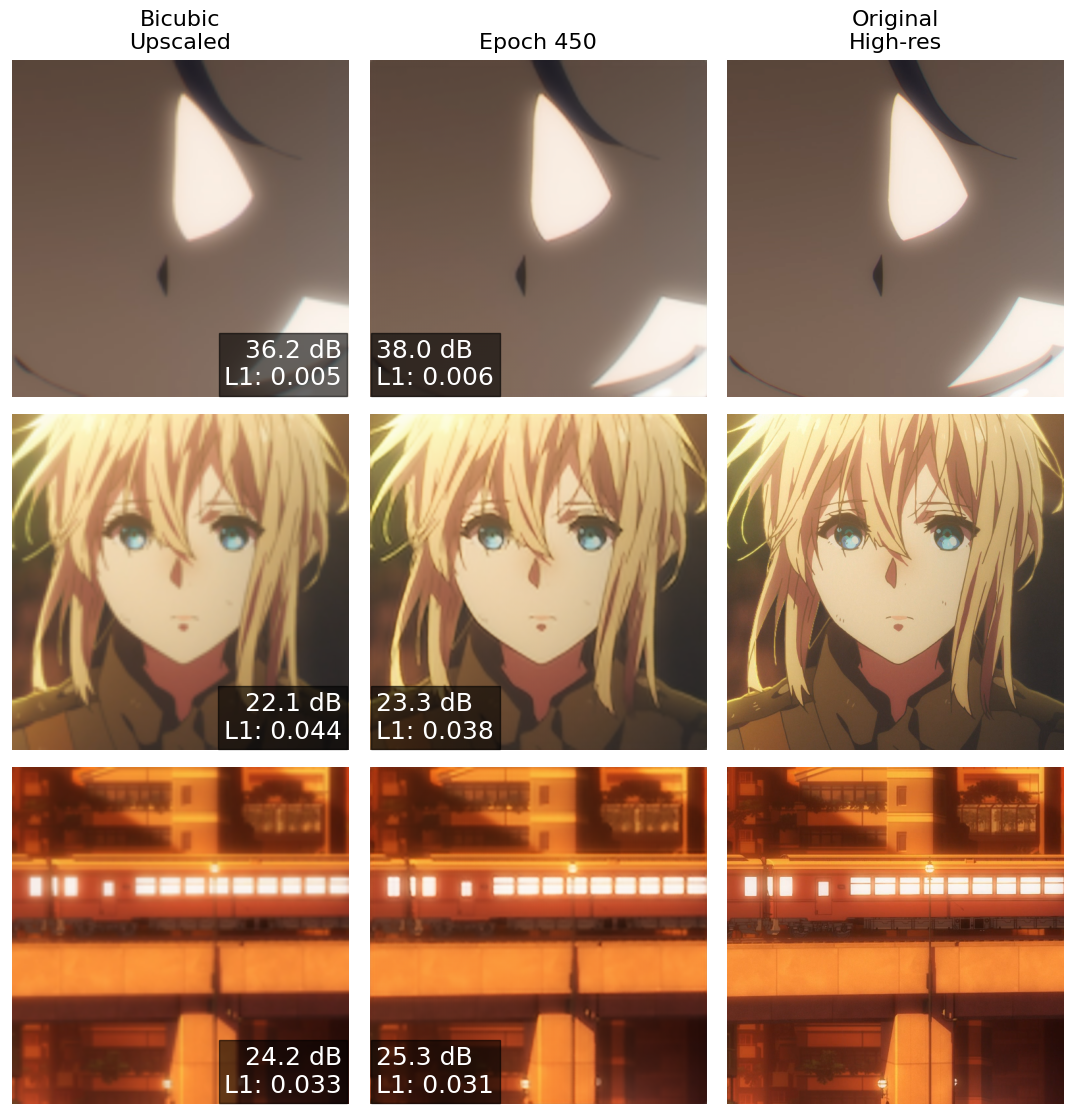

In [76]:

# ─── 1) Style & Globals ───────────────────────────────────────────────────────
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 20
})
# Which epochs to compare
epochs = [450]
# Your test images
image_paths = [
    "dataset/assault_lily_bouquet_1.png",
    "dataset/violet_evergarden_0.png",
    "dataset/magia_record_s1_0.png"
]

# ─── 3) Image‐preprocessing helper ─────────────────────────────────────────────
def process_image(img: Image.Image,
                  crop_size: int = 512,
                  low_res_size: int = 128):
    """Center‐crop to crop_size, downscale to low_res_size, and return tensors."""
    w, h = img.size
    if min(w, h) < crop_size:
        scale = crop_size / min(w, h) * 1.2
        img = img.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
        w, h = img.size

    left = (w - crop_size)//2
    top  = (h - crop_size)//2
    crop = img.crop((left, top, left+crop_size, top+crop_size))
    lr   = crop.resize((low_res_size, low_res_size), Image.BICUBIC)

    to_t = T.ToTensor()
    hr_t = to_t(crop) * 2.0 - 1.0
    lr_t = to_t(lr)   * 2.0 - 1.0
    return crop, lr, hr_t.unsqueeze(0), lr_t.unsqueeze(0)

# ─── 4) Prepare figure & column titles ────────────────────────────────────────
n_rows = len(image_paths)
n_cols = len(epochs) + 2   # bicubic, each epoch, original

fig = plt.figure(figsize=(4*n_cols, 4*n_rows))
gs  = GridSpec(n_rows, n_cols, figure=fig, wspace=0.05, hspace=0.05)

col_labels = ["Bicubic\nUpscaled"] + \
             [f"Epoch {e}" for e in epochs] + \
             ["Original\nHigh-res"]
for c, label in enumerate(col_labels):
    ax = fig.add_subplot(gs[0, c])
    ax.set_title(label, pad=8)
    ax.axis("off")

# ─── 5) Loop over images ───────────────────────────────────────────────────────
for r, img_path in enumerate(image_paths):
    # Load & preprocess
    img = Image.open(img_path).convert("RGB")
    _, _, hr_t, lr_t = process_image(img)
    hr_t = hr_t.to(device)
    lr_t = lr_t.to(device)

    # ----- 5a) Bicubic baseline + PSNR + L1 -----
    with torch.no_grad():
        baseline_t = F.interpolate(
            lr_t,
            size=(hr_t.shape[2], hr_t.shape[3]),
            mode="bilinear",
            align_corners=False
        )
    mse_b = F.mse_loss(baseline_t, hr_t).item()
    psnr_b = -10 * np.log10(mse_b)
    l1_b = F.l1_loss(baseline_t, hr_t).item()

    lr_np = baseline_t.cpu().squeeze(0).permute(1,2,0).numpy() * 0.5 + 0.5
    lr_np = np.clip(lr_np, 0, 1)

    # ----- 5b) SR outputs + PSNR & L1 for each epoch -----
    sr_imgs = []
    metrics = []  # list of (psnr, l1)
    for e in epochs:
        ckpt = f"weights/SR4_epoch_{e}.pth"
        model.load_state_dict(torch.load(ckpt, map_location=device))
        model.eval()

        with torch.no_grad():
            sr_t = model(lr_t)  # output in [-1,1]
        mse = F.mse_loss(sr_t, hr_t).item()
        psnr = -10 * np.log10(mse)
        l1 = F.l1_loss(sr_t, hr_t).item()

        sr_np = sr_t.cpu().squeeze(0).permute(1,2,0).numpy() * 0.5 + 0.5
        sr_np = np.clip(sr_np, 0, 1)

        sr_imgs.append(sr_np)
        metrics.append((psnr, l1))

    # ----- 5c) Original high-res -----
    hr_np = hr_t.cpu().squeeze(0).permute(1,2,0).numpy() * 0.5 + 0.5
    hr_np = np.clip(hr_np, 0, 1)

    # ── Plot bicubic + annotate PSNR & L1 ───────────────────────────────────────
    ax = fig.add_subplot(gs[r, 0])
    ax.imshow(lr_np)
    ax.axis("off")
    ax.text(
        0.98, 0.02,
        f"{psnr_b:.1f} dB\nL1: {l1_b:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=18,
        color="white",
        bbox=dict(facecolor="black", alpha=0.6, pad=4)
    )
    ax.set_ylabel(
        os.path.basename(img_path),
        rotation=0, labelpad=40, va="center", fontsize=14
    )

    # ── Plot SR columns with PSNR & L1 ─────────────────────────────────────────
    for c, (sr_img, (psnr, l1)) in enumerate(zip(sr_imgs, metrics), start=1):
        ax = fig.add_subplot(gs[r, c])
        ax.imshow(sr_img)
        ax.axis("off")
        ax.text(
            0.02, 0.02,
            f"{psnr:.1f} dB\nL1: {l1:.3f}",
            transform=ax.transAxes,
            ha="left", va="bottom",
            fontsize=18,
            color="white",
            bbox=dict(facecolor="black", alpha=0.6, pad=4)
        )

    # ── Plot original HR ────────────────────────────────────────────────────────
    ax = fig.add_subplot(gs[r, -1])
    ax.imshow(hr_np)
    ax.axis("off")

# ─── 6) Final layout & save ───────────────────────────────────────────────────
plt.subplots_adjust(top=0.92, left=0.1, right=0.98, bottom=0.05)
plt.savefig("epoch_comparison_psnr_l1.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\ruhalis\AppData\Local\Temp\ipykernel_11968\18017878.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

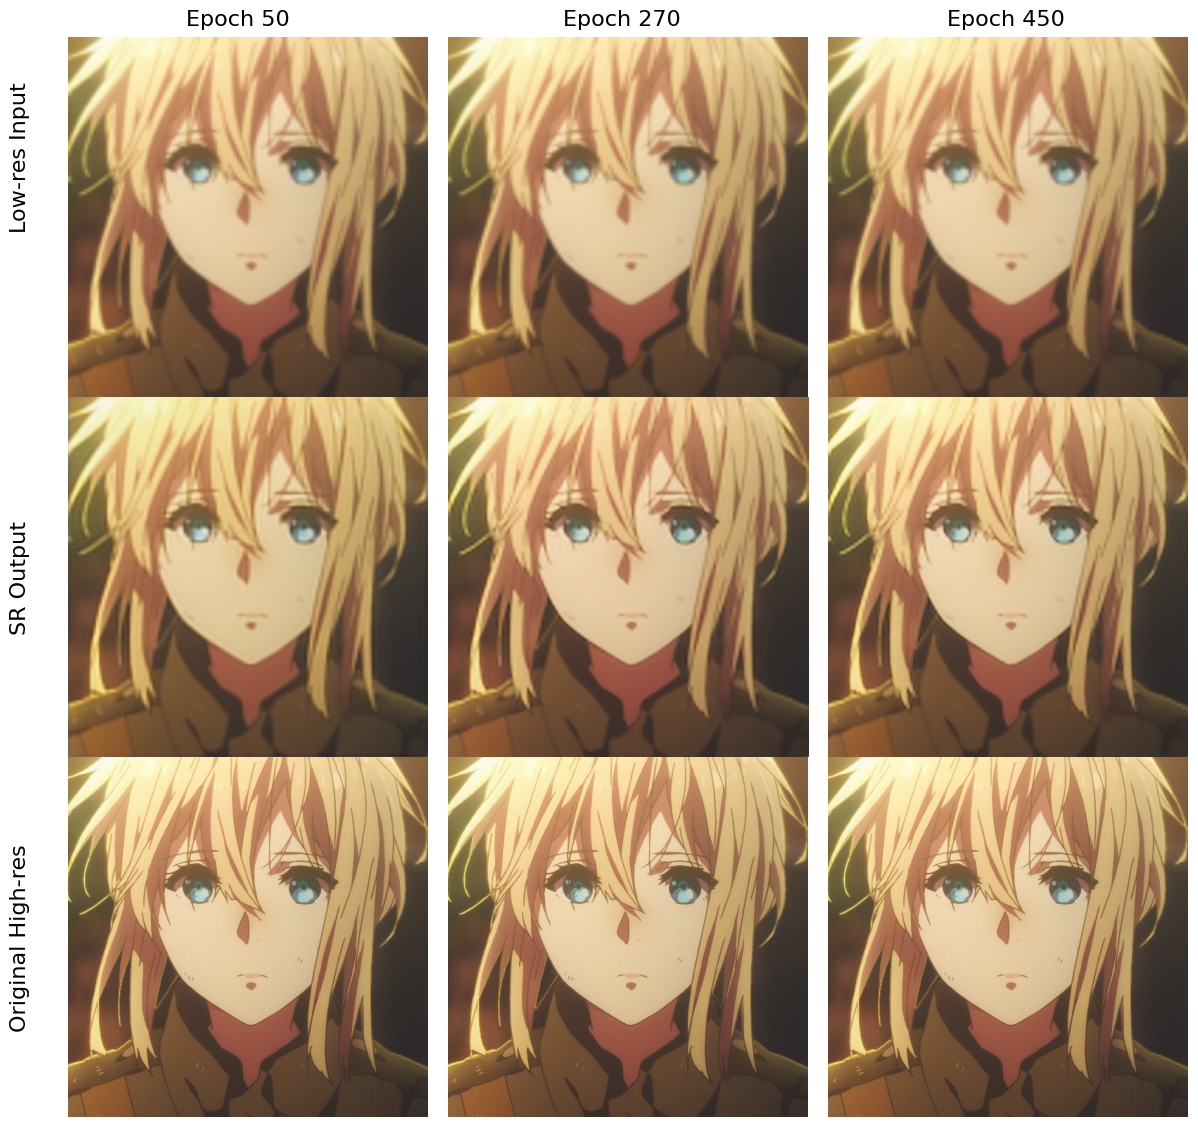

In [59]:
# Set style and increase font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

# Epoch checkpoints to compare
epochs = [50, 270, 450]

# Image path - replace with your actual image path
image_path = "dataset/violet_evergarden_0.png"  # Update with your image path

# Function to process image
def process_image(img, crop_size=512, low_res_size=128):
    # Get dimensions
    width, height = img.size
    
    # If image is smaller than crop_size, resize it up
    if width < crop_size or height < crop_size:
        scale = crop_size / min(width, height) * 1.2  # Scale up a bit
        new_width, new_height = int(width * scale), int(height * scale)
        img = img.resize((new_width, new_height), Image.LANCZOS)
        width, height = img.size
    
    # Calculate center crop coordinates
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    
    # Crop to square
    img_cropped = img.crop((left, top, right, bottom))
    
    # Create low-res version by resizing down
    img_low_res = img_cropped.resize((low_res_size, low_res_size), Image.BICUBIC)
    
    # Convert both to tensors [-1, 1] range as expected by your model
    to_tensor = T.ToTensor()
    hr_tensor = to_tensor(img_cropped) * 2.0 - 1.0
    lr_tensor = to_tensor(img_low_res) * 2.0 - 1.0
    
    return img_cropped, img_low_res, hr_tensor, lr_tensor

# Load the image
original_img = Image.open(image_path).convert('RGB')

# Process the image
img_hr, img_lr, hr_tensor, lr_tensor = process_image(original_img)

# Add batch dimension and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_tensor = lr_tensor.unsqueeze(0).to(device)
hr_tensor = hr_tensor.unsqueeze(0).to(device)

# Upsample low-res for display (traditional upscaling)
lr_upsampled = F.interpolate(lr_tensor, size=(512, 512), mode='bilinear', align_corners=False)
lr_np = lr_upsampled.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
lr_np = np.clip(lr_np, 0, 1)

# Original high-res
hr_np = hr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
hr_np = np.clip(hr_np, 0, 1)

# Create figure with zero spacing between subplots
fig, axes = plt.subplots(
    3, len(epochs),
    figsize=(len(epochs) * 4, 12),
    gridspec_kw={'wspace': 0.0, 'hspace': 0.0}
)

# Add column headers with epoch numbers at the top of the figure
for i, epoch in enumerate(epochs):
    fig.text(0.2 + i * 0.32, 0.91, f"Epoch {epoch}", ha='center', fontsize=16)

# First row: Show low-res upscaled for all columns
for i in range(len(epochs)):
    axes[0, i].imshow(lr_np)
    axes[0, i].axis('off')

# Process with each epoch model for the middle row
for i, epoch in enumerate(epochs):
    model_path = f"weights/SR4_epoch_{epoch}.pth"
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
            sr_np = sr_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5
            sr_np = np.clip(sr_np, 0, 1)
        
        axes[1, i].imshow(sr_np)
        axes[1, i].axis('off')
        
    except Exception as e:
        axes[1, i].text(0.5, 0.5, f"Error loading epoch {epoch}",
                        ha='center', va='center', transform=axes[1, i].transAxes)
        axes[1, i].axis('off')

# Third row: Show original high-res for all columns
for i in range(len(epochs)):
    axes[2, i].imshow(hr_np)
    axes[2, i].axis('off')

# Add row labels
fig.text(0.01, 0.8, "Low-res Input", fontsize=16, rotation=90, va='center')
fig.text(0.01, 0.45, "SR Output", fontsize=16, rotation=90, va='center')
fig.text(0.01, 0.15, "Original High-res", fontsize=16, rotation=90, va='center')

# Adjust outer margins to leave room only for headers/labels
fig.subplots_adjust(left=0.05, right=1.00, top=0.9, bottom=0.00)

# Save and display
plt.savefig('epoch_comparison_single_image.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()